In [50]:
#Import library

import pandas as pd
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import numpy as np
import xgboost as xgb


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import plotly.graph_objects as go

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer

import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.utils import resample, shuffle
from sklearn.ensemble import RandomForestClassifier

from adjustText import adjust_text






## Importing csv data

In [3]:
df = pd.read_csv('News_Final.csv', index_col=0)

In [4]:
df.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


## Cleaning 

### Removing of NaN values

In [5]:
df.isnull().sum()

IDLink                 0
Title                  0
Headline              15
Source               279
Topic                  0
PublishDate            0
SentimentTitle         0
SentimentHeadline      0
Facebook               0
GooglePlus             0
LinkedIn               0
dtype: int64

In [6]:
df.dropna(subset=['Headline','Source'], axis=0, inplace=True)

In [7]:
df.isnull().sum()

IDLink               0
Title                0
Headline             0
Source               0
Topic                0
PublishDate          0
SentimentTitle       0
SentimentHeadline    0
Facebook             0
GooglePlus           0
LinkedIn             0
dtype: int64

## Preprocessing Headline and Titles

In [8]:
def preprocessing(text):
    
    # Tokenize the string into words
    tokens = word_tokenize(text)
    
    # Remove non-alphabetic tokens, such as punctuation
    words = [word.lower() for word in tokens if word.isalpha()]
    
    # Filter stopwords
    stop_words = set(stopwords.words('english'))
    
    words = [word for word in words if not word in stop_words]
    
    return(" ".join(words))

### Clean Headline 

In [9]:
clean_headline = []

for headline in df['Headline']:
    clean_headline.append(preprocessing(headline))

### Clean Title

In [10]:
clean_title = []

for title in df['Title']:
    clean_title.append(preprocessing(title))

## EDA

### Top 20 unigrams (Headline)

In [34]:
def get_top_n_words(text, n):
    
    vec = CountVectorizer()
    bag_of_words = vec.fit_transform(text)
    sum_words = bag_of_words.sum(axis=0) #Sum of words appearance throughout the rows
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(clean_headline, 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df1 = df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
df1.iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 words')

obama 30772
economy 26076
microsoft 24697
president 23232
quot 16016
barack 13268
said 9736
new 9454
economic 9087
year 6102
first 5164
one 5075
palestine 4812
windows 4779
growth 4729
world 4194
last 4155
washington 4075
us 4039
state 3984


In [35]:
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

### Top 20 bigrams (Headline)

In [36]:
def get_top_n_words(text, n):
    
    vec = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vec.fit_transform(text)
    sum_words = bag_of_words.sum(axis=0) #Sum of words appearance throughout the rows
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(clean_headline, 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df2 = df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
df2.iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 words')

barack obama 13166
president barack 11199
president obama 7365
white house 2788
obama administration 2288
obama said 1647
global economy 1441
us president 1360
economic growth 1351
prime minister 1344
donald trump 1247
united states 1191
last year 1144
economy grew 1061
supreme court 1030
per cent 1006
hillary clinton 936
european union 889
xbox one 830
washington ap 825


In [37]:
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

### Top 20 trigrams (Headline)

In [38]:
def get_top_n_words(text, n):
    
    vec = CountVectorizer(ngram_range=(3, 3))
    bag_of_words = vec.fit_transform(text)
    sum_words = bag_of_words.sum(axis=0) #Sum of words appearance throughout the rows
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(clean_headline, 20)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df3 = df3.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
df3.iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 words')

president barack obama 11153
us president barack 1179
barack obama said 747
ap president barack 727
washington ap president 508
washington president barack 438
state union address 414
first lady michelle 412
gross domestic product 405
lady michelle obama 395
ceo satya nadella 355
microsoft nasdaq msft 335
white house said 323
international monetary fund 304
economy grew percent 294
final state union 291
cnn president barack 274
leave european union 269
barack obama says 261
president obama said 252


In [39]:
df3 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

### Top 20 unigrams (Title)

In [40]:
def get_top_n_words(text, n):
    
    vec = CountVectorizer()
    bag_of_words = vec.fit_transform(text)
    sum_words = bag_of_words.sum(axis=0) #Sum of words appearance throughout the rows
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(clean_title, 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df4 = df4.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
df4.iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 words')

obama 27646
economy 26432
microsoft 20497
palestine 3924
us 3735
new 3672
says 3514
president 3072
economic 2928
windows 2733
china 2700
global 2188
trump 2061
growth 1933
palestinian 1588
world 1499
state 1398
could 1344
one 1271
israel 1268


In [41]:
df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

### Top 20 bigrams (Title) 

In [42]:
def get_top_n_words(text, n):
    
    vec = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vec.fit_transform(text)
    sum_words = bag_of_words.sum(axis=0) #Sum of words appearance throughout the rows
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(clean_title, 20)
for word, freq in common_words:
    print(word, freq)
df5 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df5 = df5.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
df5.iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 words')

president obama 2069
us economy 1310
global economy 1271
barack obama 1184
obama says 860
obama administration 818
china economy 755
white house 751
supreme court 744
microsoft surface 609
xbox one 598
michelle obama 578
donald trump 519
uk economy 501
surface pro 458
economic growth 457
world economy 438
hillary clinton 390
obama visit 382
sharing economy 375


In [43]:
df5 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

### Top 20 trigrams (Title)

In [44]:
def get_top_n_words(text, n):
    
    vec = CountVectorizer(ngram_range=(3, 3))
    bag_of_words = vec.fit_transform(text)
    sum_words = bag_of_words.sum(axis=0) #Sum of words appearance throughout the rows
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(clean_title, 20)
for word, freq in common_words:
    print(word, freq)
df6 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df6 = df6.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
df6.iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 words')

microsoft surface pro 258
president barack obama 154
obama supreme court 118
supreme court nominee 118
ceo satya nadella 109
microsoft surface book 109
microsoft ceo satya 106
microsoft corporation msft 102
obama gun control 82
obama state union 76
final state union 74
microsoft lumia xl 70
market economy status 69
state union address 69
us economy grew 66
obama white house 65
economy grows percent 65
low oil prices 64
fastest growing economy 63
garland supreme court 61


In [45]:
df6 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

### Words Comparison (Headline & Title unigrams)

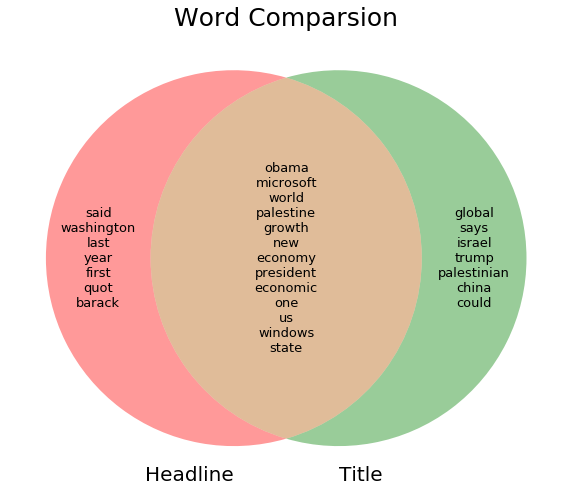

In [46]:
plt.figure(figsize=(10,10))
plt.title('Word Comparsion',fontsize=25)

set_a = set(df1['ReviewText'][:20])
set_b = set(df4['ReviewText'][:20])

venn = venn2([set_a,set_b],set_labels=['Headline','Title'])

venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)
venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)

### Words Comparison (Headline & Title bigrams)

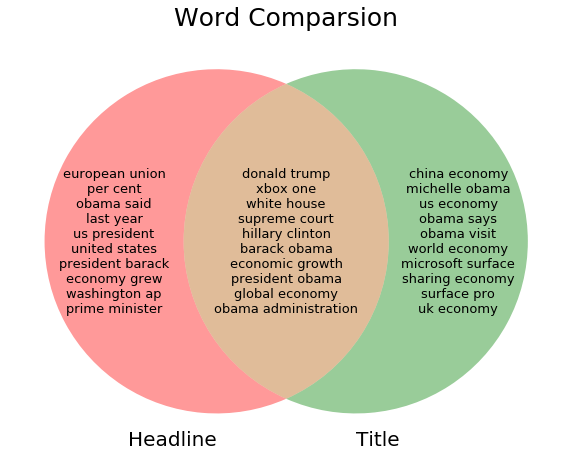

In [47]:
plt.figure(figsize=(10,10))
plt.title('Word Comparsion',fontsize=25)

set_a = set(df2['ReviewText'][:20])
set_b = set(df5['ReviewText'][:20])

venn = venn2([set_a,set_b],set_labels=['Headline','Title'])

venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)
venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)

### Words Comparison (Headline & Title trigrams)

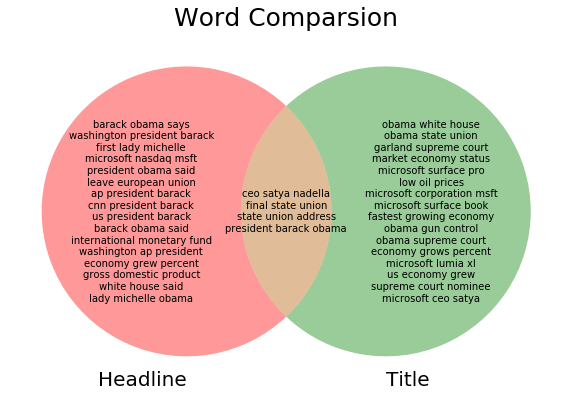

In [48]:
plt.figure(figsize=(10,10))
plt.title('Word Comparsion',fontsize=25)

set_a = set(df3['ReviewText'][:20])
set_b = set(df6['ReviewText'][:20])

venn = venn2([set_a,set_b],set_labels=['Headline','Title'])

venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('100').set_size(10)
venn.get_label_by_id('110').set_size(10)
venn.get_label_by_id('010').set_size(10)
venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)

## Train Word2Vec model based on Google corpus

In [17]:
# Load Word2Vec model (trained on an enormous Google corpus)

model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True) 

In [18]:
model.vector_size

300

In [19]:
# Test out the model dictionary 

word_economy = model['economy']

#First 20 components

word_economy[:20]

array([ 0.18847656, -0.0703125 , -0.16113281,  0.03857422, -0.04956055,
       -0.23046875, -0.15722656, -0.16992188,  0.17089844, -0.01208496,
       -0.16015625, -0.02770996,  0.05932617,  0.00491333, -0.13769531,
        0.39257812,  0.06201172,  0.30859375,  0.12890625, -0.07373047],
      dtype=float32)

### Create vector model for headline and title


In [20]:
#Tokenise Headline
cleaned_headline_token = ' '.join(clean_headline)
cleaned_headline_token = word_tokenize(cleaned_headline_token) 


In [21]:
#Tokenise Title
cleaned_title_token = ' '.join(clean_title)
cleaned_title_token = word_tokenize(cleaned_title_token)

### Headline Vector list

In [22]:
#Headline Vector list
headline_vector = [model[word] for word in cleaned_headline_token if word in model.vocab]

headline_vector_word = [word for word in cleaned_headline_token if word in model.vocab]

headline_zip = zip(headline_vector_word, headline_vector)

headline_vec_dict = dict(headline_zip)
df_headline = pd.DataFrame.from_dict(headline_vec_dict, orient='index')
df_headline.to_csv('df_headline.csv',index=False)
df_headline.shape

(30744, 300)

In [23]:
df_headline.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
obama,-0.123535,0.072266,0.171875,0.402344,-0.125977,-0.302734,-0.044922,-0.015259,0.171875,-0.043457,...,-0.055420,-0.138672,-0.064453,-0.104004,-0.267578,-0.205078,-0.111816,-0.022461,0.066895,0.026855
lays,-0.052246,-0.057373,0.193359,-0.106934,0.298828,-0.166016,0.137695,0.125000,-0.032227,-0.096191,...,-0.172852,-0.484375,-0.228516,0.168945,-0.291016,0.003647,0.041016,0.229492,0.248047,0.353516
wreath,0.166992,0.199219,-0.082031,0.142578,0.055420,-0.102539,0.103516,-0.138672,0.030884,-0.007050,...,0.015503,-0.085938,-0.173828,0.109863,0.096680,-0.102051,0.119629,-0.287109,-0.085938,0.188477
arlington,-0.006653,0.023926,0.141602,0.160156,0.052490,0.113281,-0.125000,-0.138672,-0.136719,0.023071,...,0.130859,0.104004,0.064453,0.068848,-0.069336,-0.137695,-0.000572,-0.125977,-0.086914,0.112793
national,-0.135742,0.175781,0.117188,0.078613,0.052490,-0.238281,0.092773,-0.083984,0.061523,-0.062500,...,0.034180,-0.039551,0.034424,-0.075195,0.006775,-0.110840,0.069336,-0.068359,0.032471,-0.009338


### Title Vector list

In [24]:
#Title vector list 
title_vector = [model[word] for word in cleaned_title_token if word in model.vocab]

title_vector_word = [word for word in cleaned_title_token if word in model.vocab]

title_zip = zip(title_vector_word, title_vector)

title_vec_dict = dict(title_zip)
df_title = pd.DataFrame.from_dict(title_vec_dict, orient='index')
df_title.to_csv('df_title.csv',index=False)
df_title.shape

(21805, 300)

In [25]:
df_title.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
obama,-0.123535,0.072266,0.171875,0.402344,-0.125977,-0.302734,-0.044922,-0.015259,0.171875,-0.043457,...,-0.055420,-0.138672,-0.064453,-0.104004,-0.267578,-0.205078,-0.111816,-0.022461,0.066895,0.026855
lays,-0.052246,-0.057373,0.193359,-0.106934,0.298828,-0.166016,0.137695,0.125000,-0.032227,-0.096191,...,-0.172852,-0.484375,-0.228516,0.168945,-0.291016,0.003647,0.041016,0.229492,0.248047,0.353516
wreath,0.166992,0.199219,-0.082031,0.142578,0.055420,-0.102539,0.103516,-0.138672,0.030884,-0.007050,...,0.015503,-0.085938,-0.173828,0.109863,0.096680,-0.102051,0.119629,-0.287109,-0.085938,0.188477
arlington,-0.006653,0.023926,0.141602,0.160156,0.052490,0.113281,-0.125000,-0.138672,-0.136719,0.023071,...,0.130859,0.104004,0.064453,0.068848,-0.069336,-0.137695,-0.000572,-0.125977,-0.086914,0.112793
national,-0.135742,0.175781,0.117188,0.078613,0.052490,-0.238281,0.092773,-0.083984,0.061523,-0.062500,...,0.034180,-0.039551,0.034424,-0.075195,0.006775,-0.110840,0.069336,-0.068359,0.032471,-0.009338


In [26]:
title_vector_word

['obama',
 'lays',
 'wreath',
 'arlington',
 'national',
 'cemetery',
 'look',
 'health',
 'chinese',
 'economy',
 'global',
 'economy',
 'back',
 'finland',
 'gdp',
 'expands',
 'tourism',
 'govt',
 'spending',
 'buoys',
 'thai',
 'economy',
 'january',
 'solutions',
 'host',
 'annual',
 'spring',
 'microsoft',
 'dynamics',
 'user',
 'group',
 'obama',
 'stars',
 'pay',
 'musical',
 'tribute',
 'ray',
 'charles',
 'fire',
 'claims',
 'barn',
 'hancock',
 'county',
 'microsoft',
 'new',
 'windows',
 'ad',
 'targets',
 'apple',
 'microsoft',
 'project',
 'centennial',
 'seen',
 'universal',
 'desktop',
 'office',
 'microsoft',
 'sneaks',
 'onto',
 'android',
 'android',
 'sneaks',
 'onto',
 'windows',
 'greek',
 'economy',
 'grows',
 'pct',
 'fourth',
 'quarter',
 'big',
 'data',
 'internet',
 'things',
 'add',
 'uk',
 'economy',
 'report',
 'dev',
 'edition',
 'costs',
 'new',
 'conker',
 'game',
 'microsoft',
 'word',
 'mac',
 'review',
 'subtle',
 'yet',
 'massive',
 'leap',
 'forwar

## Dimensionality Reduction: t-SNE

### t-SNE Headline

In [27]:
#!pip install adjustText

In [28]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 5)

# Use only 500 rows to shorten processing time
tsne_df_headline = tsne.fit_transform(df_headline[:500])

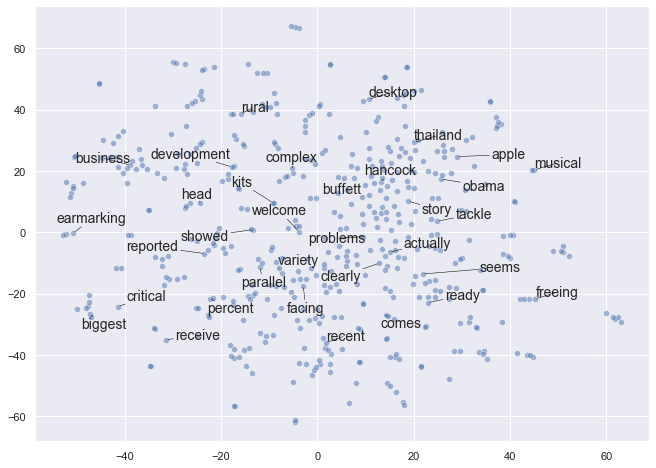

In [29]:
sns.set()

fig, ax = plt.subplots(figsize = (11, 8))
sns.scatterplot(tsne_df_headline[:, 0], tsne_df_headline[:, 1], alpha = 0.5)

#initialize list of texts
texts = []
words_to_plot = list(np.arange(0, 500, 15))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df_headline[word, 0], tsne_df_headline[word, 1], df_headline.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

### t-SNE Title

In [30]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 10)

# Use only 500 rows to shorten processing time
tsne_df_title = tsne.fit_transform(df_title[:500])

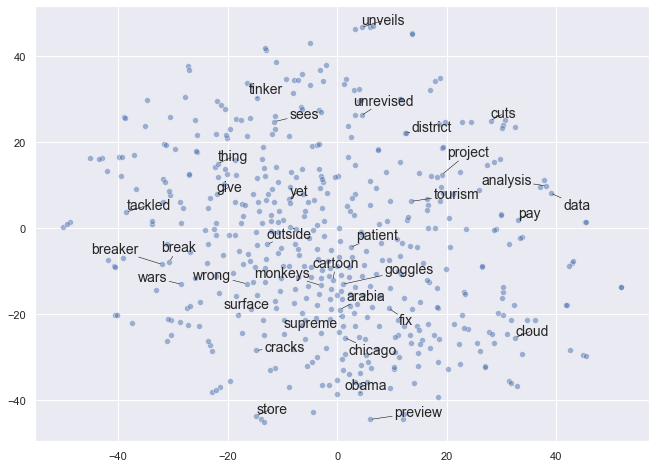

In [31]:
sns.set()

fig, ax = plt.subplots(figsize = (11, 8))
sns.scatterplot(tsne_df_title[:, 0], tsne_df_title[:, 1], alpha = 0.5)

#initialize list of texts
texts = []
words_to_plot = list(np.arange(0, 500, 15))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df_title[word, 0], tsne_df_title[word, 1], df_title.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

## Averaging Word Embeddings

In [32]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [33]:
headline_list = [headline for headline in df['Headline']]

In [34]:
title_list = [title for title in df['Title']]

In [35]:
# Preprocess the corpus (HEADLINE)
corpus = [preprocess(headline) for headline in headline_list]

# Remove docs that don't include any words in W2V's vocab
corpus, headline_list = filter_docs(corpus, headline_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, headline_list = filter_docs(corpus, headline_list, lambda doc: (len(doc) != 0))

10 docs removed
0 docs removed


In [36]:
# Preprocess the corpus (TITLE)
corpus_title = [preprocess(title) for title in title_list]

# Remove docs that don't include any words in W2V's vocab
corpus_title, title_list = filter_docs(corpus_title, title_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus_title, title_list = filter_docs(corpus_title, title_list, lambda doc: (len(doc) != 0))

31 docs removed
0 docs removed


In [37]:
# Initialize an array for the size of the corpus (HEADLINE)
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array

In [38]:
# Initialize an array for the size of the corpus (TITLE)
x_title = []
for doc in corpus_title: # append the vector for each document
    x_title.append(document_vector(model, doc))
    
X_title = np.array(x_title) # list to array

## t-SNE for Document Vectors

### t-SNE Headline

In [39]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 20)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:500])

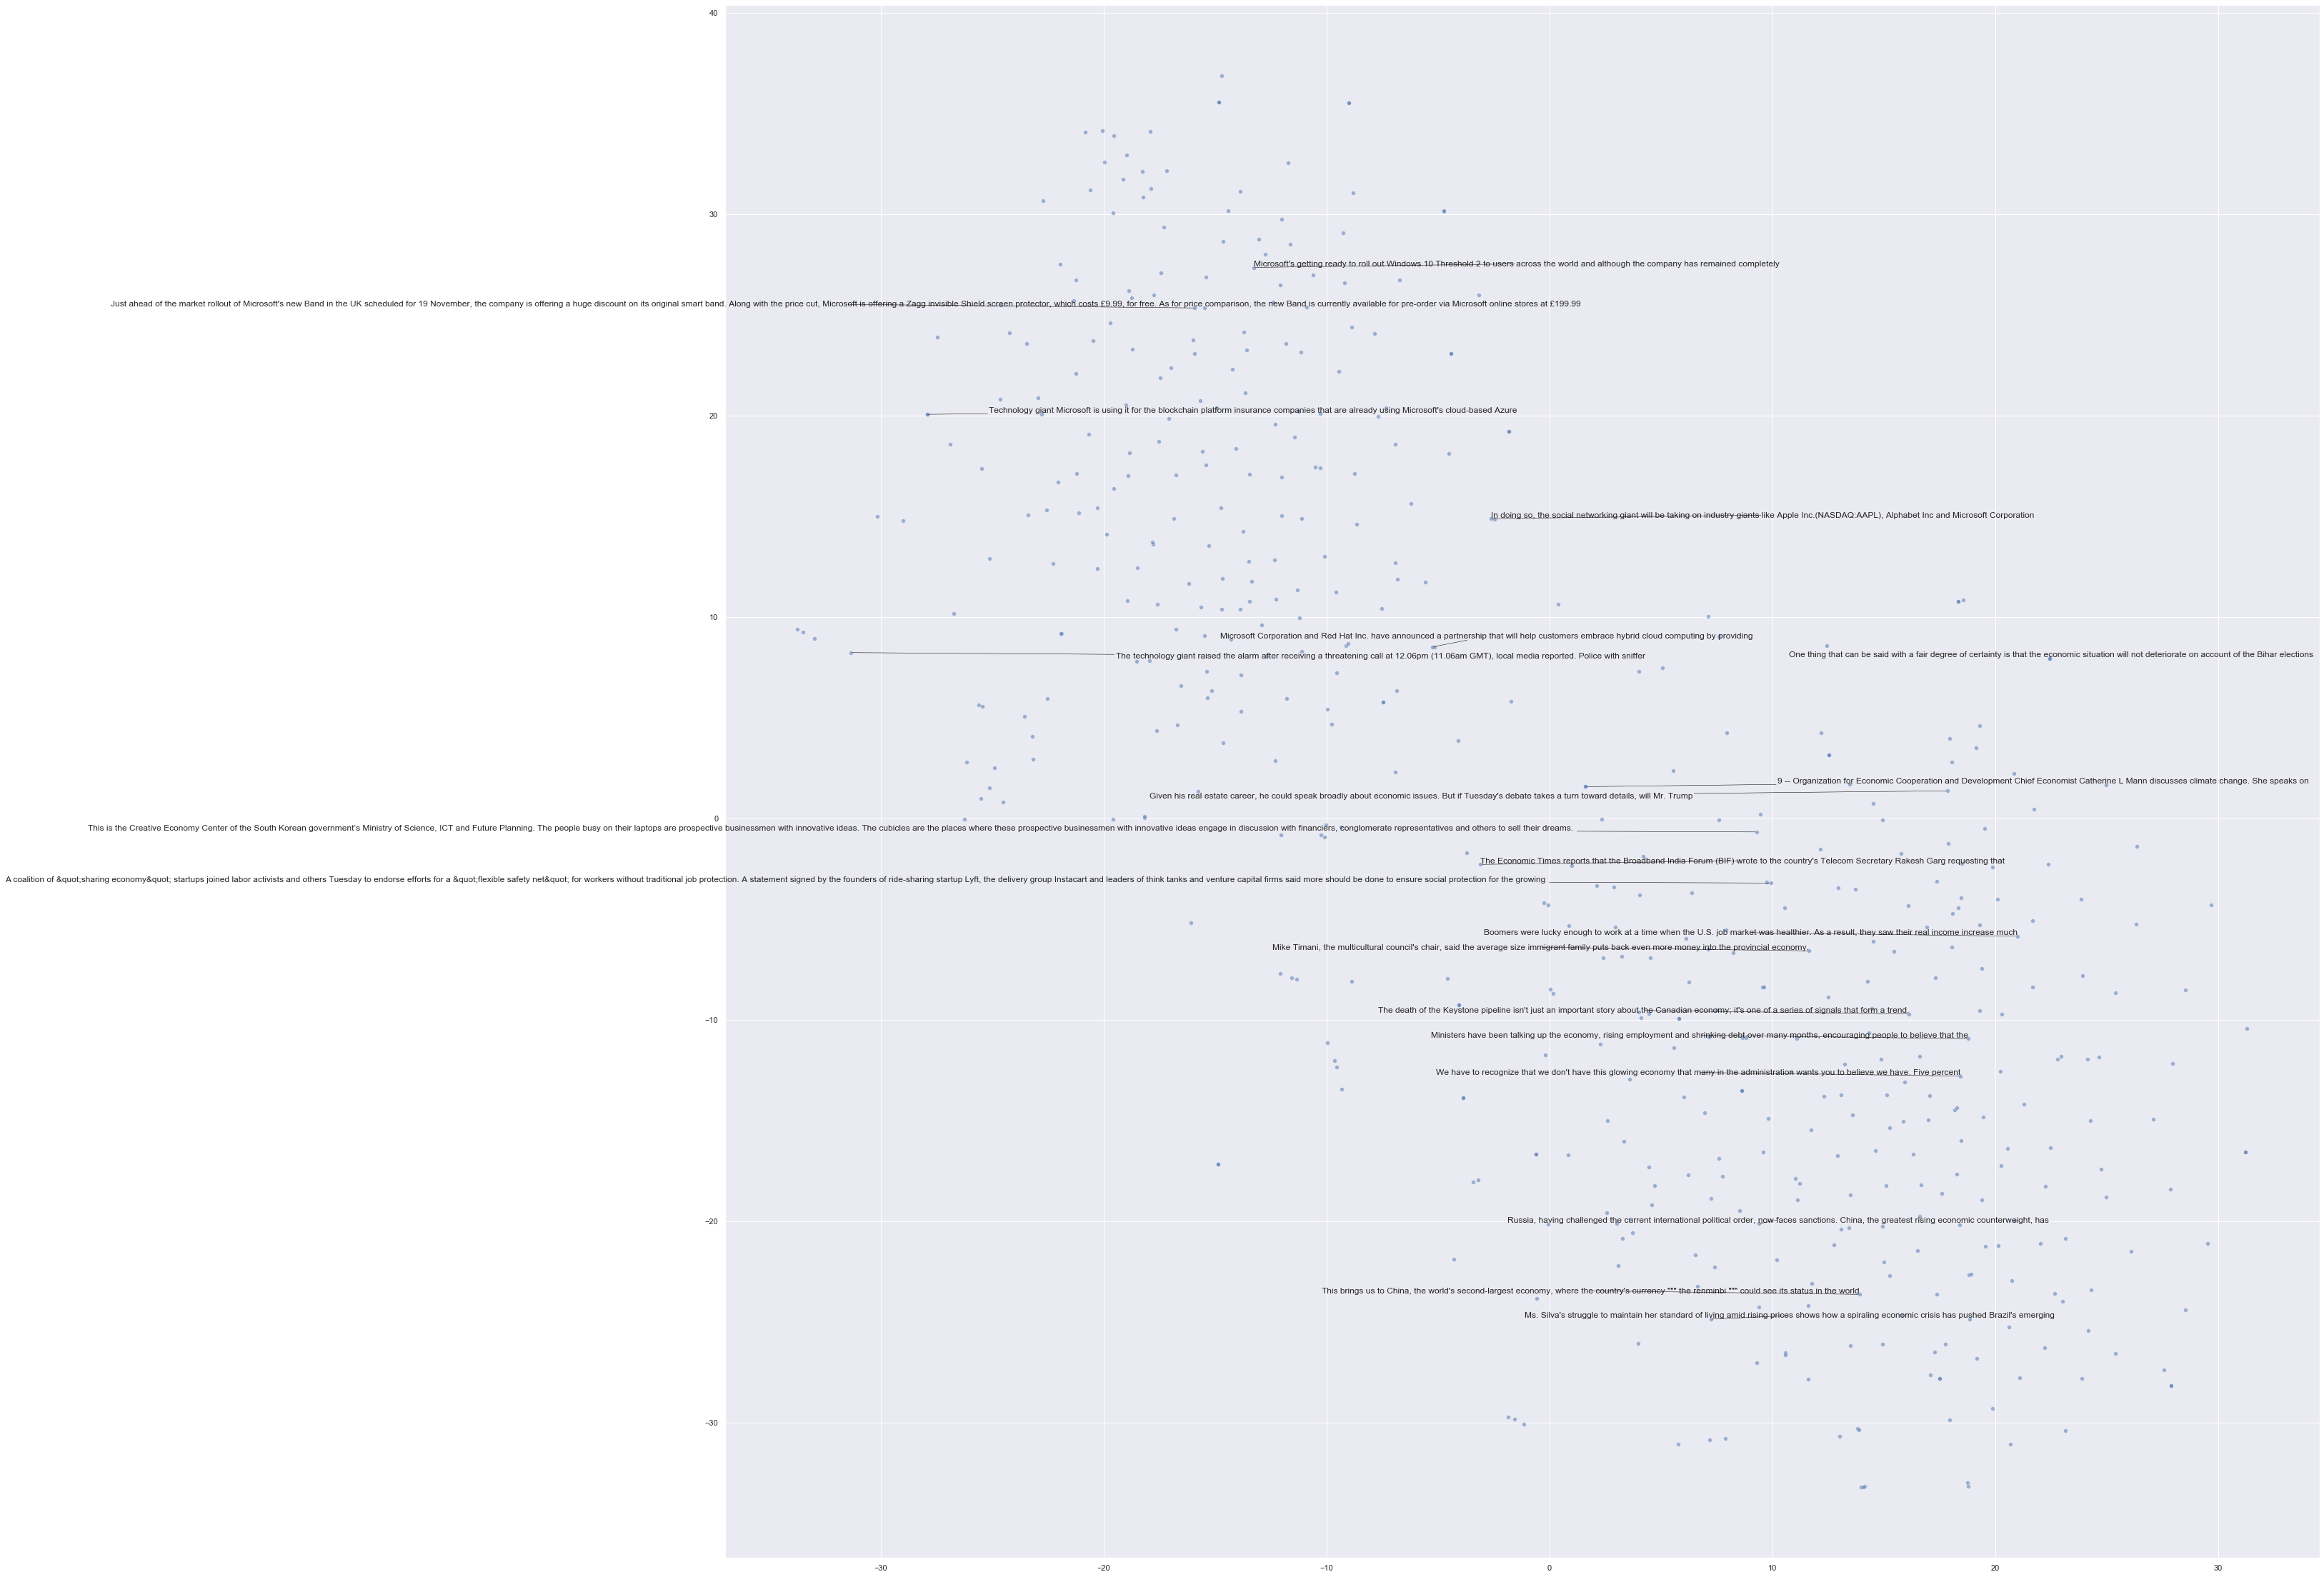

In [40]:
fig, ax = plt.subplots(figsize = (40, 40))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
headline_to_plot = list(np.arange(0, 500, 25)) # plots every 40th title in first 400 titles

# Append words to list
for headline in headline_to_plot:
    texts.append(plt.text(tsne_df[headline, 0], tsne_df[headline, 1], headline_list[headline], fontsize = 12))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.6, force_text = 0.6, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5)) 

plt.savefig('headline.png', bbox_inches='tight')
plt.show()


###  t-SNE Title

In [41]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 10)

# Use only 400 rows to shorten processing time
tsne_df_title = tsne.fit_transform(X_title[:500])

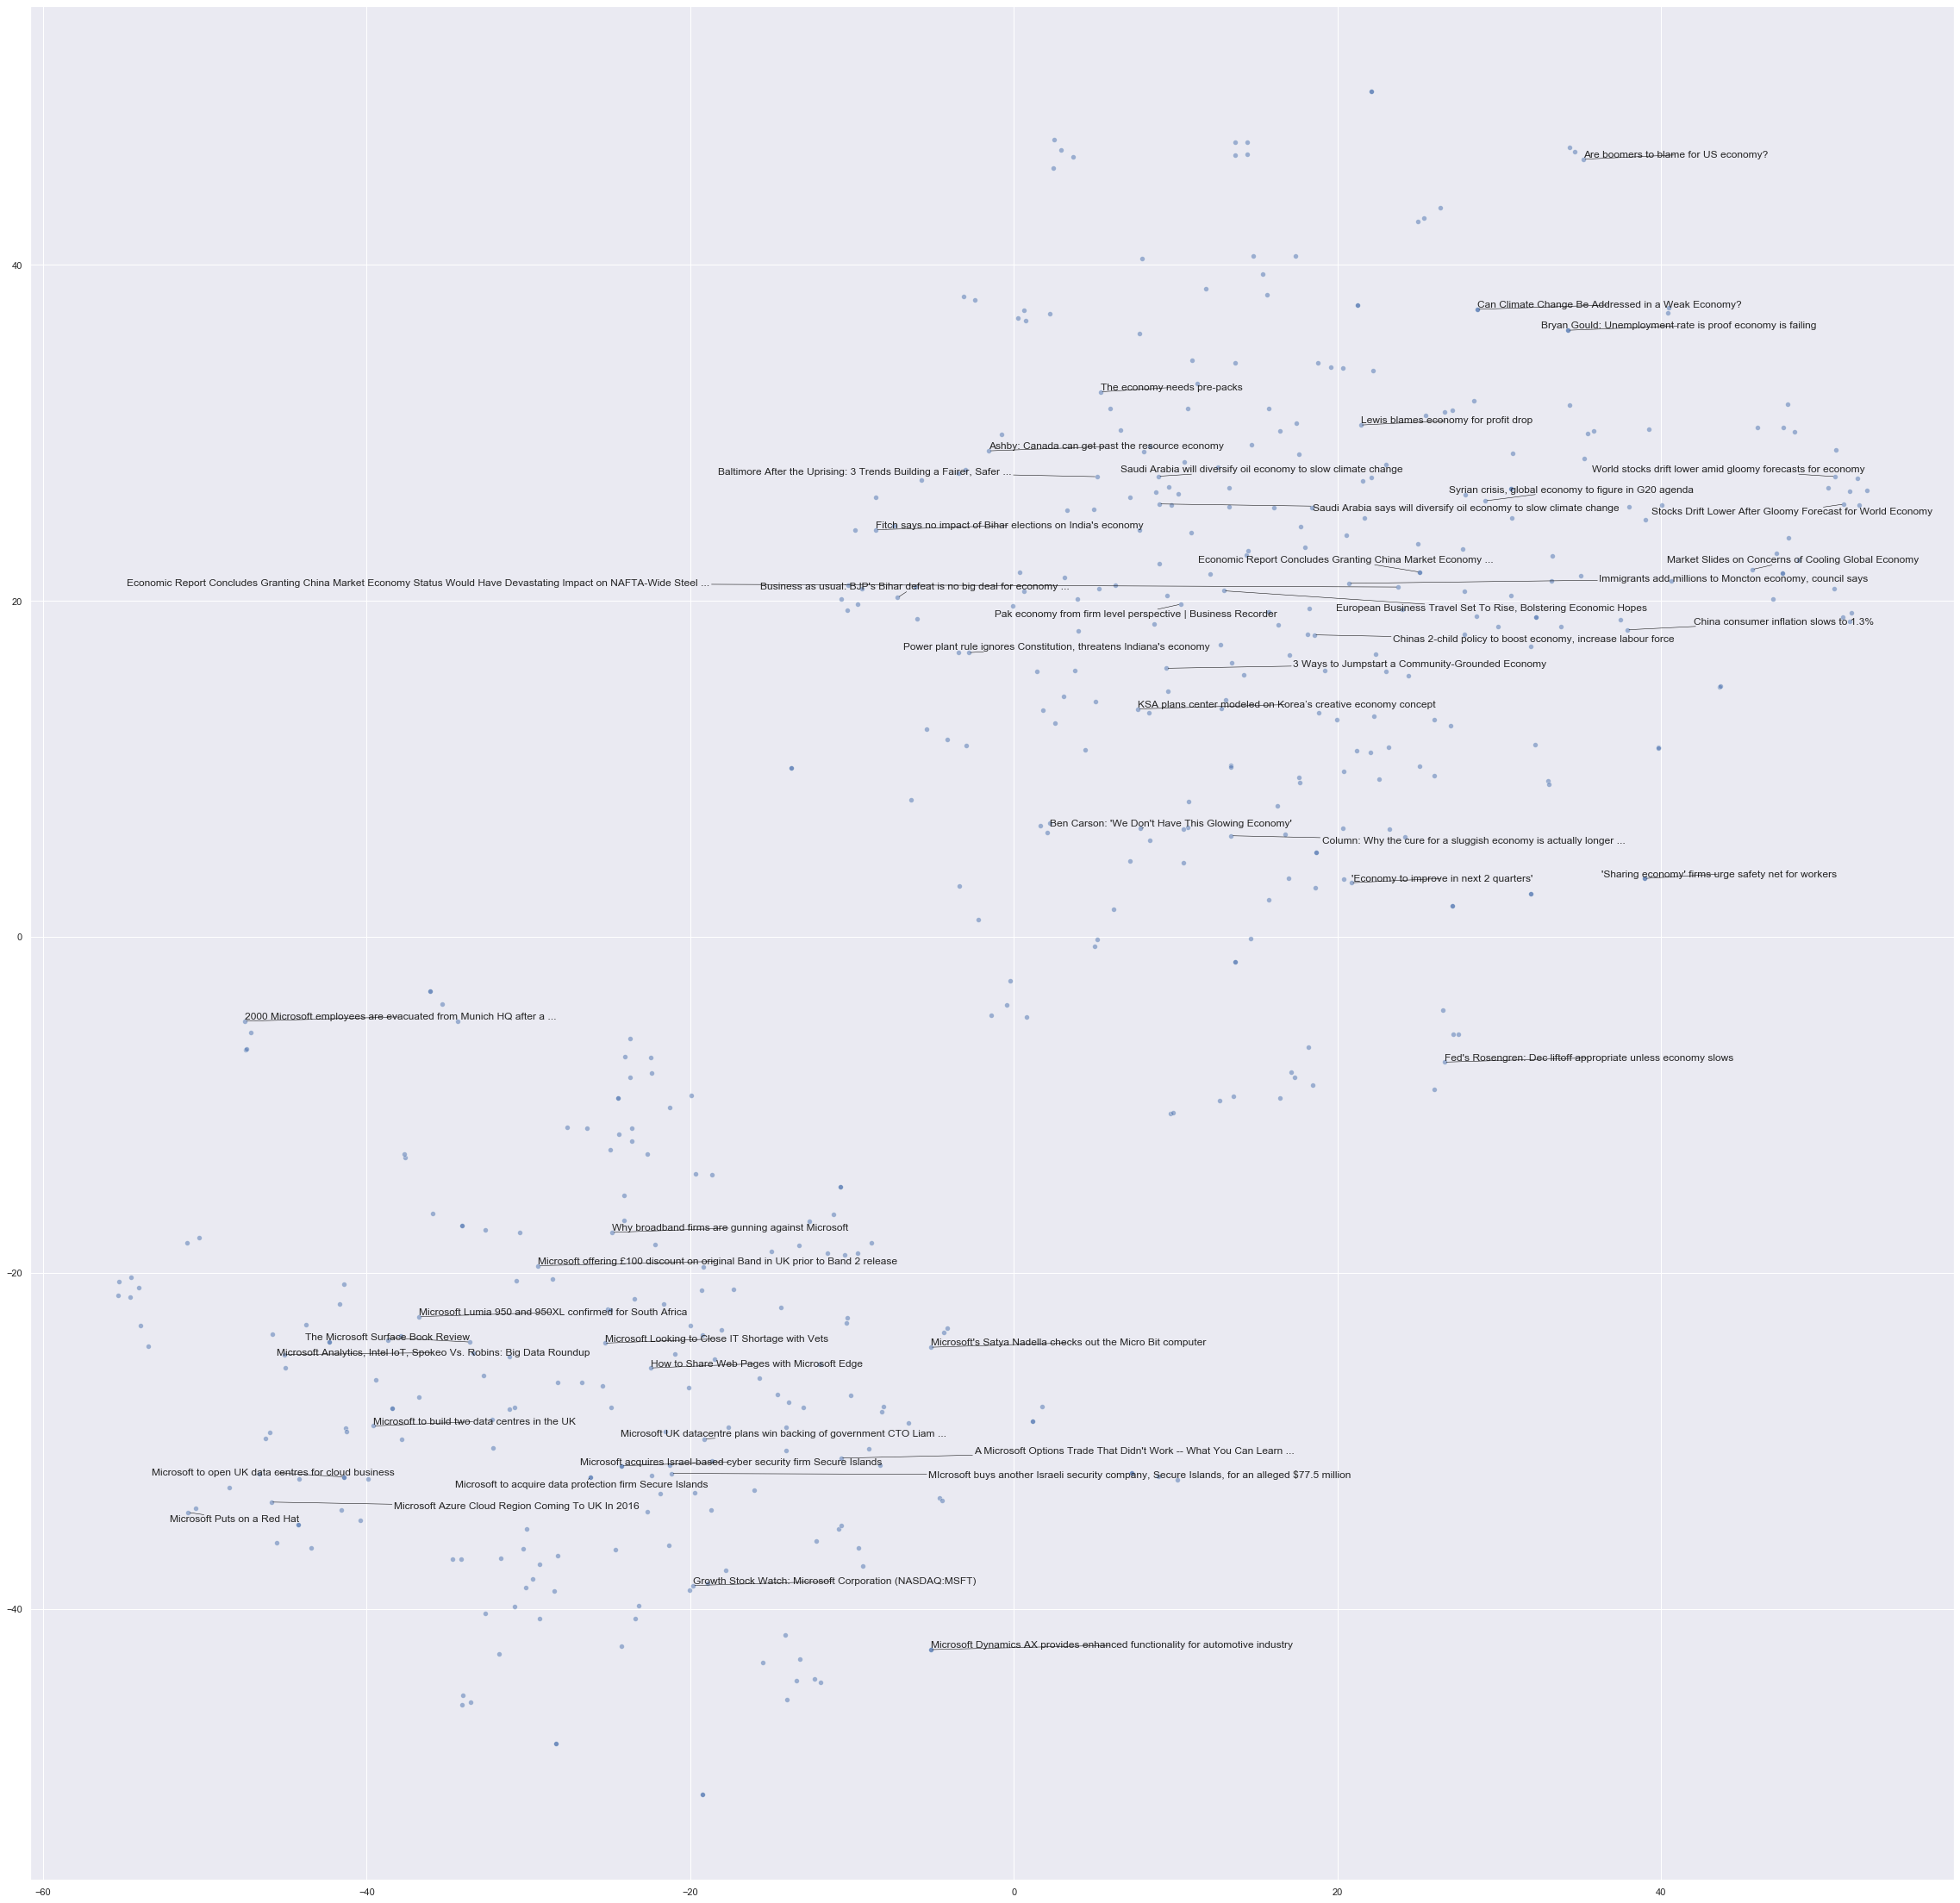

In [42]:
fig, ax = plt.subplots(figsize = (40, 40))
sns.scatterplot(tsne_df_title[:, 0], tsne_df_title[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
title_to_plot = list(np.arange(0, 500, 10)) # plots every 40th title in first 400 titles

# Append words to list
for title in title_to_plot:
    texts.append(plt.text(tsne_df_title[title, 0], tsne_df_title[title, 1], title_list[title], fontsize = 12))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.6, force_text = 0.6, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.savefig('title.png', bbox_inches='tight')
plt.show()



## Sentiment Analysis

In [43]:
# Null measurements for popularity are represented in this data as -1
# Drop all the rows where the article popularities are unknown (this is only about 11% of the data)
main_data = df.drop(df[(df.Facebook == -1) | 
                    (df.GooglePlus == -1) | 
                    (df.LinkedIn == -1)].index)

main_data.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
726,311.0,Microsoft offering £100 discount on original B...,Just ahead of the market rollout of Microsoft'...,International Business Times via Yahoo UK & Ir...,microsoft,2015-11-08 05:25:00,0.000000,-0.132812,0,0,0
727,252.0,Economy to improve though no change in last 6 ...,"&quot;In the coming six months, there seems to...",IANS India Private Limited/Yahoo India News vi...,economy,2015-11-08 05:40:00,-0.082022,0.205537,0,0,0
728,227.0,Economy to improve though no change in last 6 ...,"New Delhi, Nov 8 (IANS) Majority of Indian bus...",IANS via Yahoo Maktoob News,economy,2015-11-08 05:48:00,-0.082022,0.186968,0,0,0
729,307.0,Microsoft scales back free online storage plans,NEW YORK — Microsoft is getting stingy with on...,The Columbian,microsoft,2015-11-08 06:54:00,0.106303,-0.207333,0,0,0
730,207.0,IDC predicts the emergence of ‘DX economy’,KUCHING: The global digital economy is about t...,The Borneo Post,economy,2015-11-08 08:34:00,0.000000,0.003189,1,0,0


In [44]:
# Get the list of top 12 sources by number of articles
source_names = list(main_data['Source'].value_counts()[:12].index)
source_colors = list(sns.husl_palette(12, h=.5))

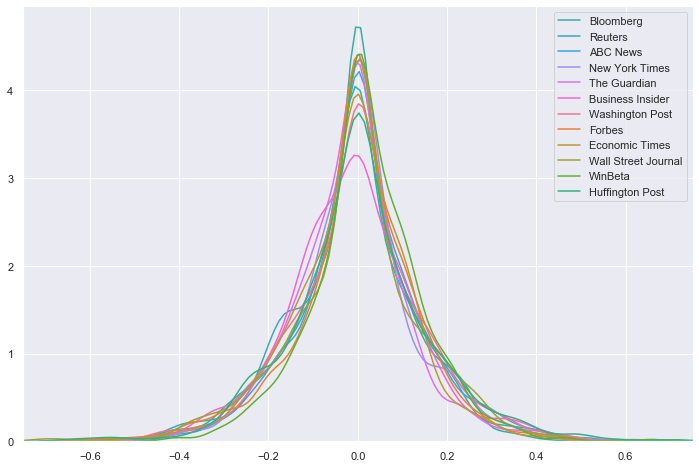

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))

for source, color in zip(source_names, source_colors):
    sns.distplot(main_data.loc[main_data['Source'] == source]['SentimentTitle'],
                               ax=ax, hist=False, label=source, color=color)
    ax.set_xlabel('')
    
plt.xlim(-0.75, 0.75)
plt.show()

In [46]:
# Group by Source, then get descriptive statistics for title sentiment
source_info = main_data.groupby('Source')['SentimentTitle'].describe()
# Recall that `source_names` contains the top 12 sources
# We'll also sort by highest standard deviation
source_info.loc[source_names].sort_values('std', ascending=False)[['std', 'min', 'max']]

,std,min,max
Source,,,
Huffington Post,0.158071,-0.644314,0.711512
Wall Street Journal,0.152442,-0.711512,0.617945
Business Insider,0.148298,-0.557338,0.573742
Washington Post,0.146626,-0.530340,0.504280
Reuters,0.145920,-0.585573,0.676516
New York Times,0.141851,-0.555912,0.662913
ABC News,0.141676,-0.424931,0.795495
Forbes,0.138622,-0.618718,0.455132
Bloomberg,0.138444,-0.632712,0.612372


## Popularity and Sentiment analysis

In [47]:
#Drop all rows where popularity are unknown

df = df.drop(df[(df.Facebook == -1)|
               (df.GooglePlus == -1)|
               (df.LinkedIn == -1)].index)



In [48]:
df.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
726,311.0,Microsoft offering £100 discount on original B...,Just ahead of the market rollout of Microsoft'...,International Business Times via Yahoo UK & Ir...,microsoft,2015-11-08 05:25:00,0.000000,-0.132812,0,0,0
727,252.0,Economy to improve though no change in last 6 ...,"&quot;In the coming six months, there seems to...",IANS India Private Limited/Yahoo India News vi...,economy,2015-11-08 05:40:00,-0.082022,0.205537,0,0,0
728,227.0,Economy to improve though no change in last 6 ...,"New Delhi, Nov 8 (IANS) Majority of Indian bus...",IANS via Yahoo Maktoob News,economy,2015-11-08 05:48:00,-0.082022,0.186968,0,0,0
729,307.0,Microsoft scales back free online storage plans,NEW YORK — Microsoft is getting stingy with on...,The Columbian,microsoft,2015-11-08 06:54:00,0.106303,-0.207333,0,0,0
730,207.0,IDC predicts the emergence of ‘DX economy’,KUCHING: The global digital economy is about t...,The Borneo Post,economy,2015-11-08 08:34:00,0.000000,0.003189,1,0,0


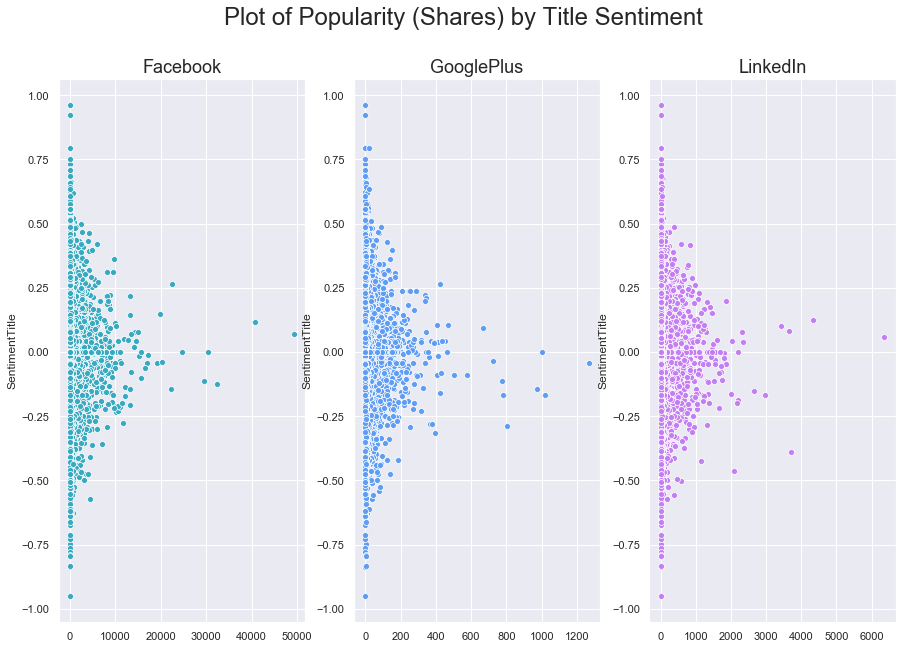

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

subplots = [a for a in ax]
platforms = ['Facebook', 'GooglePlus', 'LinkedIn']
colors = list(sns.husl_palette(10, h=.5)[1:4]) 

for platform, subplot, color in zip(platforms, subplots, colors):
    sns.scatterplot(x = df[platform], y = df['SentimentTitle'], ax=subplot, color=color)
    subplot.set_title(platform, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Plot of Popularity (Shares) by Title Sentiment', fontsize=24)

plt.show()

## Popularity Prediction (Titles)

In [50]:
pca = PCA(n_components=15, random_state=10)

# as a reminder, x is the array with our 300-dimensional vectors
reduced_vec = pca.fit_transform(x_title)
df_w_vectors = pd.DataFrame(reduced_vec)

df_w_vectors['Title'] = title_list
# Use pd.concat to match original titles with their vectors
main_w_vectors = pd.concat((df_w_vectors, df), axis=1)

# Get rid of vectors that couldn't be matched with the main_df
main_w_vectors.dropna(axis=0, inplace=True)

In [51]:
# Drop all non-numeric, non-dummy columns, for feeding into the models
cols_to_drop = ['IDLink', 'Title', 'Headline', 'PublishDate', 'Source'] 

data_only_df = pd.get_dummies(main_w_vectors, columns = ['Topic']).drop(columns=cols_to_drop)

In [52]:
data_only_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,Topic_economy,Topic_microsoft,Topic_obama,Topic_palestine
726,-0.478958,-0.234613,0.216262,0.042853,0.160453,0.052407,0.169449,0.043662,-0.085395,-0.078731,...,0.047581,0.000000,-0.132812,0.0,0.0,0.0,0,1,0,0
727,-0.469820,-0.305575,-0.195190,0.129916,0.118462,0.084454,0.292135,-0.277288,-0.208054,-0.046627,...,0.038081,-0.082022,0.205537,0.0,0.0,0.0,1,0,0,0
728,0.492144,-0.206593,-0.032544,0.166634,0.211913,0.210242,-0.101757,-0.108066,-0.002708,0.062363,...,-0.083329,-0.082022,0.186968,0.0,0.0,0.0,1,0,0,0
729,0.513497,-0.402787,-0.091579,0.116539,0.131681,0.340702,-0.057692,-0.037276,0.031177,-0.031613,...,-0.025696,0.106303,-0.207333,0.0,0.0,0.0,0,1,0,0
730,0.491778,-0.470198,0.153994,0.020393,-0.157390,0.328058,-0.062936,-0.039109,0.168668,0.036539,...,0.059080,0.000000,0.003189,1.0,0.0,0.0,1,0,0,0


### Extracting features and target (Facebook)

In [53]:
#FACEBOOK as target

X = data_only_df.drop(['Facebook', 'GooglePlus', 'LinkedIn'], axis=1)
y = data_only_df['Facebook']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [55]:
# StandardScaler

ss = StandardScaler()
ss_X_train = ss.fit_transform(X_train)
ss_X_test = ss.transform(X_test)

### XGBRegressor Basemodel

In [56]:
# Instantiate XGRegressor

xgreg = xgb.XGBRegressor(random_state=2)

In [59]:
xgreg = xgreg.fit(ss_X_train, y_train)

In [60]:
y_pred = xgreg.predict(ss_X_test)

In [61]:
mean_squared_error(y_test, y_pred)

467632.2024705753

In [62]:
# Train Score
xgreg.score(ss_X_train, y_train)

0.16513876946443584

In [63]:
# Test Score
xgreg.score(ss_X_test, y_test)

0.01858041251111875

### XGBRegressor with GridSearchCV

In [72]:
params = {
    'n_estimators' : [100, 200],
    'max_depth' : [3, 9, 15],
    'learning_rate' : [0.1, 0.2, 0.01],
    'subsample' : [0.6, 0.7, 0.8],
    'colsample_bytree' : [0.6, 0.7, 0.8]
    
}

In [73]:
xgreg_grid = GridSearchCV(
    xgreg,
    param_grid=params,
    verbose=100,
    cv= 3,
    n_jobs=-1,
)

xgreg_grid.fit(ss_X_train, y_train)

print(xgreg_grid.best_score_)
print(xgreg_grid.best_params_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
Memmapping (shape=(52910, 21), dtype=float64) to new file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int6

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    5.2s
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35274,), dtype=int64).
Pickling array (shape=(17636,), dtype=int64).
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.2s
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_

Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.9s
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35274,), dtype=int64).
Pickling array (shape=(17636,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.9s
Memmapping (

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.3s
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   49.3s
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35274,), dtype=int64).
Pickling array (shape=(17636,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:  1.2min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:  1.3min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.8min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:  1.8min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.4min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35274,), dtype=int64).
Pickling array (shape=(17636,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:  2.4min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 111 tasks      | elapsed:  2.8min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.8min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35274,), dtype=int64).
Pickling array (shape=(17636,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:  3.4min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  3.4min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  4.0min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35274,), dtype=int64).
Pickling array (shape=(17636,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.0min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  4.4min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 163 tasks      | elapsed:  4.4min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35274,), dtype=int64).
Pickling array (shape=(17636,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 179 tasks      | elapsed:  5.0min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  5.0min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.8min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35274,), dtype=int64).
Pickling array (shape=(17636,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  5.8min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  6.1min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:  6.1min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35274,), dtype=int64).
Pickling array (shape=(17636,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:  6.9min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 231 tasks      | elapsed:  7.0min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 247 tasks      | elapsed:  7.7min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35274,), dtype=int64).
Pickling array (shape=(17636,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:  7.7min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  8.1min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  8.1min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35274,), dtype=int64).
Pickling array (shape=(17636,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:  8.8min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:  8.8min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 298 tasks      | elapsed:  9.6min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35274,), dtype=int64).
Pickling array (shape=(17636,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 299 tasks      | elapsed:  9.6min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 316 tasks      | elapsed: 10.2min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35274,), dtype=int64).
Pickling array (shape=(17636,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed: 10.2min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed: 10.9min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed: 11.0min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35274,), dtype=int64).
Pickling array (shape=(17636,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 350 tasks      | elapsed: 11.6min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 351 tasks      | elapsed: 11.6min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 367 tasks      | elapsed: 12.5min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35274,), dtype=int64).
Pickling array (shape=(17636,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed: 12.6min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 13.3min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 385 tasks      | elapsed: 13.3min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35274,), dtype=int64).
Pickling array (shape=(17636,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed: 14.1min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 14.1min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 15.1min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35274,), dtype=int64).
Pickling array (shape=(17636,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 419 tasks      | elapsed: 15.1min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 435 tasks      | elapsed: 15.7min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 436 tasks      | elapsed: 15.7min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35274,), dtype=int64).
Pickling array (shape=(17636,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 452 tasks      | elapsed: 16.7min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 453 tasks      | elapsed: 16.8min
Memmapping (shape=(52910, 21), dtype=float64) to old file /var/folders/nk/3crz_xfs2gs10xk0rl8_jgw00000gn/T/joblib_memmapping_folder_892_2505612451/892-10995737808-38601fc595094889a4752d061ae06b51.pkl
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(52910,), dtype=float64).
Pickling array (shape=(52910,), dtype=int64).
Pickling array (shape=(35273,), dtype=int64).
Pickling array (shape=(17637,), dtype=int64).
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 475 out of 486 | elapsed: 17.8min remaining:   24.8s
[Parallel(n_jobs=-1)]: Done 480 out of 486 | elapsed: 18.7min remaining:   14.1s
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed: 18.8min finished
0.023616236801457243
{'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}


### XGBRegressor with best_params

In [77]:
params = {
    'n_estimators' : 200,
    'max_depth' : 3,
    'learning_rate' : 0.01,
    'subsample' : 0.6,
    'colsample_bytree' : 0.6
    
}

In [78]:
xgreg_best = xgb.XGBRegressor(random_state=2, **params)

In [79]:
xgreg_best.fit(ss_X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.6, gamma=0, learning_rate=0.01,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=200, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=2, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=True, subsample=0.6)

In [80]:
y_pred = xgreg_best.predict(ss_X_test)

In [81]:
mean_squared_error(y_test, y_pred)

462615.2145754352

## Classification method

### Feature Engineering on 'Facebook' column

In [84]:
data_only_df['Facebook'].describe()

count    75586.000000
mean       127.628145
std        667.417393
min          0.000000
25%          1.000000
50%          7.000000
75%         42.000000
max      49211.000000
Name: Facebook, dtype: float64

In [86]:
# A function to create dummies for faceboook popularity and split them into 3 categories

def dummy(facebook_popularity):
    if facebook_popularity <= 1:
        return -1
    elif facebook_popularity <= 7:
        return 0
    else:
        return 1
    

In [88]:
#Create new dummies column in data_only_df

data_only_df['fb_dumb'] = data_only_df['Facebook'].apply(dummy)
data_only_df[['Facebook', 'fb_dumb']].head()

# -1:Not Popular
# 0:Neutral
# 1:Popular

,Facebook,fb_dumb
726,0.0,-1
727,0.0,-1
728,0.0,-1
729,0.0,-1
730,1.0,-1


In [90]:
data_only_df['fb_dumb'].value_counts() #75586

 1    37470
-1    21830
 0    16286
Name: fb_dumb, dtype: int64

### Compensating for imbalanced class

In [151]:
#Classifying of classes based on minority and majority class

minority_class_0 = data_only_df[data_only_df['fb_dumb']==0]
minority_class_1 = data_only_df[data_only_df['fb_dumb']==-1]
majority_class = data_only_df[data_only_df['fb_dumb']==1]


#Resamples minority class with replacement
minority_upsampled_0 = resample(minority_class_0,
                             replace=True,
                             n_samples=majority_class.shape[0],
                             random_state=42)

minority_upsampled_1 = resample(minority_class_1,
                               replace=True,
                               n_samples=majority_class.shape[0],
                               random_state=42)

#Combined majority class with the minorities class
rebalanced = pd.concat([minority_upsampled_0, majority_class])
rebalanced_2 = pd.concat([minority_upsampled_1, rebalanced])

rebalanced_2.fb_dumb.value_counts()


-1    37470
 1    37470
 0    37470
Name: fb_dumb, dtype: int64

In [161]:
df_balanced = shuffle(rebalanced_2, random_state=42)
df_balanced.reset_index(drop=True, inplace=True)


df_balanced.head()

,0,1,2,3,4,5,6,7,8,9,...,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,Topic_economy,Topic_microsoft,Topic_obama,Topic_palestine,fb_dumb
0,0.526585,-0.418419,-0.147863,-0.185102,-0.098101,-0.079742,0.263635,0.093266,-0.233528,-0.007934,...,-0.220971,-0.086111,12.0,0.0,32.0,1,0,0,0,1
1,0.742173,-0.110073,0.126790,0.239398,-0.017645,-0.126739,0.106506,0.230166,0.046301,-0.042297,...,-0.079057,-0.036083,4.0,0.0,0.0,1,0,0,0,0
2,-0.459079,-0.030676,-0.076128,0.061841,-0.124740,-0.304631,-0.032540,0.111095,0.042942,0.014824,...,-0.083333,-0.027120,3.0,2.0,138.0,0,1,0,0,0
3,-0.082876,0.525729,-0.086626,0.007456,-0.216129,-0.122642,0.025903,0.170766,0.035906,-0.080231,...,0.000000,-0.080316,2.0,0.0,7.0,0,1,0,0,0
4,0.009033,0.285660,-0.251691,-0.162077,0.245551,0.012421,0.028269,-0.076890,0.056698,0.100289,...,0.153093,-0.089389,5.0,0.0,0.0,1,0,0,0,0


In [182]:
#Export out the CSV

#df_balanced.to_csv('df_balanced.csv')

In [3]:
#Import CSV
df_balanced = pd.read_csv('df_balanced.csv', index_col=0)

### XGBClassifier Basemodel 

In [4]:
# Feature selection and target label

X = df_balanced.drop(['Facebook', 'GooglePlus', 'LinkedIn','fb_dumb'], axis=1)

y = df_balanced['fb_dumb']

In [5]:
# Train, test and split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
# StandardScaler

ss = StandardScaler()
ss_X_train = ss.fit_transform(X_train)
ss_X_test = ss.transform(X_test)

In [7]:
xgclass = xgb.XGBClassifier()

In [8]:
xgclass = xgclass.fit(ss_X_train, y_train)

In [9]:
# Predict

y_pred = xgclass.predict(ss_X_test)

In [14]:
metrics.confusion_matrix(y_test, y_pred)

array([[5002, 4310, 1795],
       [3970, 5503, 1933],
       [2818, 3296, 5096]])

In [15]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.42      0.45      0.44     11107
           0       0.42      0.48      0.45     11406
           1       0.58      0.45      0.51     11210

    accuracy                           0.46     33723
   macro avg       0.47      0.46      0.46     33723
weighted avg       0.47      0.46      0.46     33723



### XGBClassifier GridSearch

In [18]:
params = {
    'n_estimators' : [200, 500, 1000],
    'max_depth' : [3, 9, 15, 20],
    'learning_rate' : [0.1, 0.01, 0.001],
    'subsample' : [0.6, 0.7, 0.8],
    'colsample_bytree' : [0.6, 0.7, 0.8]    
}

In [ ]:
xgclass_grid = GridSearchCV(xgclass,
                            param_grid=params,
                            cv = 2,
                            verbose = 1 ,
                            n_jobs=-1
                            )

xgclass_grid.fit(ss_X_train, y_train)



Fitting 2 folds for each of 324 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 63.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 184.0min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 298.2min finished


In [20]:
print(xgclass_grid.best_score_)
print(xgclass_grid.best_params_)

0.6379325682768437
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500, 'subsample': 0.7}


### XGBClassifier with Best Params

In [22]:
params = {
    'n_estimators' : 500,
    'max_depth' : 20,
    'learning_rate' : 0.1,
    'subsample' : 0.7,
    'colsample_bytree' : 0.8    
}

In [23]:
xgclass_best = xgb.XGBClassifier(random_state=2, **params)

xgclass_best.fit(ss_X_train, y_train)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=20, min_child_weight=1, missing=None,
              n_estimators=500, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=2, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.7)

In [25]:
y_pred = xgclass_best.predict(ss_X_test)

In [28]:
metrics.confusion_matrix(y_test, y_pred)

array([[8745,  684, 1678],
       [ 704, 9568, 1134],
       [2176, 1387, 7647]])

In [29]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.75      0.79      0.77     11107
           0       0.82      0.84      0.83     11406
           1       0.73      0.68      0.71     11210

    accuracy                           0.77     33723
   macro avg       0.77      0.77      0.77     33723
weighted avg       0.77      0.77      0.77     33723



## RandomForest GridSearch

In [52]:
params = {
    'n_estimators' : [200, 500],
    'max_depth' : [15, 20],
    'min_samples_split': np.linspace(0.1, 0.5, 5),
    'min_samples_leaf' : np.linspace(0.1, 0.5, 5),
    'max_features' : [5, 10, 15]
}

In [53]:
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params,
    verbose=1,
    cv= 2,
    n_jobs=-1
    
)

rf_grid.fit(ss_X_train, y_train)

Fitting 2 folds for each of 300 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 10.1min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [54]:
model_rf = rf_grid.best_estimator_
rf_best_params = rf_grid.best_params_

In [55]:
# predict y
y_pred = pd.DataFrame(model_rf.predict_proba(ss_X_test), columns=['-1','0','1'])

In [56]:
# print results
print("Best parameters:", rf_best_params)
print("Best score:", rf_grid.best_score_)

Best parameters: {'max_depth': 20, 'max_features': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2, 'n_estimators': 500}
Best score: 0.4456136337641542


## RandomForest with Best Params 

In [42]:
params = {'max_depth': 20, 
          'max_features': 5, 
          'min_samples_leaf': 0.1, 
          'min_samples_split': 0.2, 
          'n_estimators': 500}

In [43]:
rf_best = RandomForestClassifier(random_state=2, **params)

rf_best.fit(ss_X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=0.2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [44]:
y_pred = rf_best.predict(ss_X_test)

In [47]:
metrics.confusion_matrix(y_test, y_pred)

array([[6485, 2758, 1864],
       [6057, 3358, 1991],
       [3896, 2194, 5120]])

In [48]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.39      0.58      0.47     11107
           0       0.40      0.29      0.34     11406
           1       0.57      0.46      0.51     11210

    accuracy                           0.44     33723
   macro avg       0.46      0.45      0.44     33723
weighted avg       0.46      0.44      0.44     33723

